# Stim and LFP phase
## How well is the system detecting target LFP phases?

### Needs emk_neuro_analysis environment
### load LFP, DIO and time data

In [1]:
import pandas as pd
import numpy as np
from pprint import pprint
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
import itertools
from scipy.signal import sosfiltfilt, butter, hilbert
from scipy.stats import circstd
from scipy import stats
from sklearn.linear_model import LinearRegression

from emk_analysis import builder_experiment as bld_exp
from emk_neuro_analysis.lfp import iterator as lfp_iter
# from emk_neuro_analysis.position import iterator as pos_iter
# from mountainlab_pytools import mdaio
from emk_analysis import iterator as emk_iter
import pywt

from collections import deque
from pprint import pprint
from scipy import signal
from pathlib import Path
from rec_to_binaries.read_binaries import readTrodesExtractedDataFile

from clc_analysis.phase.target_selection import select_target
from clc_analysis.phase import replace_with_nearest as rn, organize_cycle as oc, align_to_events_continuous as ac, \
filter_DIO as fd
from clc_analysis.phase.filter_DIO import filter_pump_event
from clc_analysis.phase.phase_IO import read_day_param
from clc_analysis.phase.session_preprocessing import SessionData, SessionParam
from clc_analysis.phase import phase_plot as p_plot

### Experiment parameters

In [49]:
# name of experiment
experiment_name = 'clc'

experiment_phase = 'stim'

# data drive
data_disk = 'nvme1'

# directory with the preprocessed/extracted data files
dir_preprocess = f'/media/{data_disk}/Data/{experiment_name}/preprocessing/'

# Figure folder, where you want to save the output figures. Usually in your experiment folder for analysis.
dir_fig = f'/media/{data_disk}/Analysis/{experiment_name}/Results/'

# Location of track config file. 
# This is an excel spreadsheet that specifies the identities of the DIO for your experiment.
# fname_config_track = (f'/media/{data_disk}/Data/{experiment_name}/config/CLC_linear_Config_laser.xlsx')
fname_config_track = (f'/media/{data_disk}/Data/{experiment_name}/config/Maze_YF_clc_Config.xlsx')

# Location of session parameter file
# This is an excel spreadsheet that specifies the CLC parameters used in your experiment
fname_session_parameter = (f'/media/{data_disk}/Data/{experiment_name}/config/clc_session_parameter_record.xlsx')

# Location of day records. 
# This is an excel spreadsheet that lists details for each session on your experiment day.
dir_records = (f'/media/{data_disk}/Data/{experiment_name}/dayrecords/')

# chose the date - as a list
choose_dates = [ '20220908',]

# choose the epoch - as a list
epoch_list = [1, 2,]

# choose the tetrodes - as a list
tet_list = [19,]

### Build day records from track config file and experiment file

In [50]:
data_days = []
for curr_date in choose_dates:

    fname_day_record = f'{dir_records}{curr_date}_{experiment_phase}_training_record.xlsx'
    
    dict_sessions_day = bld_exp.build_day_from_file(experiment_name, 
                                track_config_file=fname_config_track,
                                day_record_file=fname_day_record)
    data_days.append(dict_sessions_day)

dict_sessions_all = bld_exp.build_all_sessions(data_days)
pprint(dict_sessions_all)

{'20220908_01': {'date': '20220908',
                 'description': 'random_stim',
                 'end': Timestamp('2022-09-08 23:55:00'),
                 'experiment': 'clc',
                 'id': 1,
                 'name': 'stim',
                 'start': Timestamp('2022-09-08 01:00:00'),
                 'tasks': {'Track 1': {'animal_id': 'siggen',
                                       'description': 'Y',
                                       'dio': {'entry_sensor': {'bit': 11,
                                                                'notes': None,
                                                                'type': 'in'},
                                               'exit_sensor': {'bit': 12,
                                                               'notes': None,
                                                               'type': 'in'},
                                               'laser_pump': {'bit': 2,
                                             

### Import LFP data

In [4]:
lfp_data, lfp_timestamp, _ = lfp_iter.iterate_lfp_load(dir_preprocess,
                                                       tet_list,
                                                       choose_dates,
                                                       epoch_list=epoch_list, 
                                                       remove_movement_artifact=False,
                                                       filter_linenoise=True,
                                                       print_debug=False)

# lfp_func.concatenate_lfptime(lfp_timestamp, df_epoch_lfp)

/home/jaiyu/.conda/envs/emk_neuro_analysis/lib/python3.6/site-packages/rec_to_binaries/read_binaries.py:73: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  return np.dtype(typearr)


Loaded /media/nvme1/Data/clc/preprocessing/20220908/20220908_clc_03_stim.LFP tet 1
filter 60Hz noise
Loaded /media/nvme1/Data/clc/preprocessing/20220908/20220908_clc_03_stim.LFP tet 19
filter 60Hz noise
Loaded /media/nvme1/Data/clc/preprocessing/20220908/20220908_clc_04_stim.LFP tet 1
filter 60Hz noise
Loaded /media/nvme1/Data/clc/preprocessing/20220908/20220908_clc_04_stim.LFP tet 19
filter 60Hz noise
Loaded /media/nvme1/Data/clc/preprocessing/20220908/20220908_clc_01_stim.LFP tet 1
filter 60Hz noise
Loaded /media/nvme1/Data/clc/preprocessing/20220908/20220908_clc_01_stim.LFP tet 19
filter 60Hz noise
Loaded /media/nvme1/Data/clc/preprocessing/20220908/20220908_clc_02_stim.LFP tet 1
filter 60Hz noise
Loaded /media/nvme1/Data/clc/preprocessing/20220908/20220908_clc_02_stim.LFP tet 19
filter 60Hz noise


### Transform time

In [5]:
time_dict = {}

fs_time = 30000
fs_filter = 1500

for i in lfp_timestamp.items():
    time_curr = i[1]
    time_dict.update({i[0]:{'timestamp':np.array(time_curr),
                            'time':(np.array(time_curr) - time_curr[0])/fs_time}})

<IPython.core.display.Javascript object>


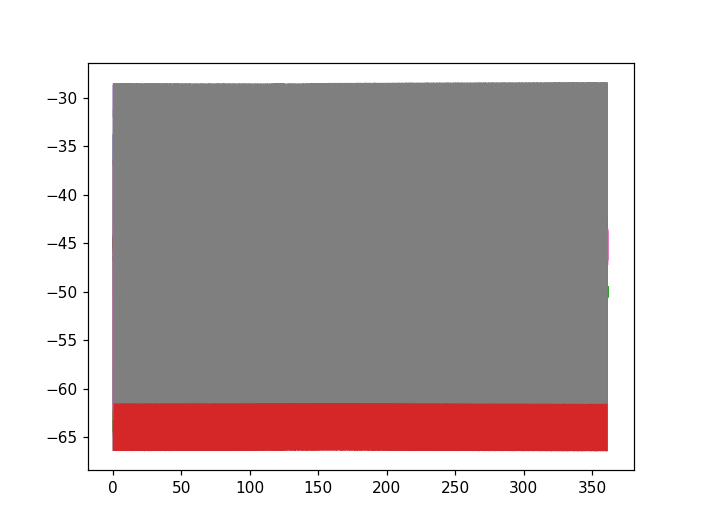

In [6]:
%matplotlib notebook

for i, (k, v) in enumerate(lfp_data.items()):
    for e in epoch_list:
    # for e in [3, 4]:
    
        plt.plot((np.array(lfp_timestamp.get(e))-np.array(lfp_timestamp.get(e))[0])/fs_time,
                 np.array(v.get(e))/1000+5*(i-10), lw=.15)

### Import DIO data

In [7]:
# Load DIO
%matplotlib notebook

plot_DIO = False

filter_retrigger = 1000
# filter_retrigger = 0

# time plotting settings
tick_minutes = mdates.MinuteLocator(interval=5)
tick_minutes_fmt = mdates.DateFormatter('%H:%M')
tick_minor = mdates.SecondLocator(interval=10)

# Specify parameters
dict_sensor_pump_map = {3: {'pump': 'laser_pump'},
                        # 6: {'sensor': 'reward_1_sensor'},
                        # 5: {'sensor': 'reward_1_sensor'},
                       }

# list dio to extract
# list_dio = [2, 5]
# y_label = ['laser',
#            'reward 1',]

list_dio = [3,]
y_label = ['laser',]

# plot each session
# get data for each animal
# initiate output
dict_dio_out = {}

dict_dio_in = {}

# for animal_id in ['clc', ]:
for animal_id in ['6004879', 'siggen']:
    
    print(animal_id)
    cls_behavior = emk_iter.ProcessBehavior(dict_sessions_all,
                                            experiment_name, trodes_version=2)
    cls_behavior.filter_animals(animal_id)
    dict_rewards = cls_behavior.count_reward_delivered()
    
    if not dict_rewards:
        continue
        
    df_pump = cls_behavior.report_reward_delivered(remove_zeroth=False,
                                                   output_raw=False,
                                                   filter_retrigger=None)
    
    df_sensor = cls_behavior.report_triggers(remove_zeroth=False,
                                             output_raw=False,
                                             filter_retrigger=filter_retrigger)
    
    # get unique sessions
    sessions_unique = np.sort(df_pump['session'].unique())
    print(sessions_unique)
    n_subplots = len(sessions_unique)
    
    if plot_DIO:
        fig = plt.figure(figsize=(10, n_subplots*3+2))
        axs = fig.subplots(n_subplots, 1)
        if n_subplots == 1:
            axs = [axs, ]
            sessions_unique = [sessions_unique[0], ]
    
    else:
        axs = [0]*len(sessions_unique)
    
    # divide into sessions
    for sn, (ax, session) in enumerate(zip(axs, sessions_unique)):
        
        # get session times
        curr_start = dict_sessions_all.get(session).get('start')
        curr_end = dict_sessions_all.get(session).get('end')
        
        # get sensor and pump times
#         df_sensor_curr = df_sensor[df_sensor['session']==session]
#         df_sensor_curr = df_sensor_curr[(df_sensor_curr['on_time_sys']>=curr_start)
#                                         & (df_sensor_curr['on_time_sys']<curr_end)]
#         dict_dio_in.update({int(session.split('_')[1]): df_sensor_curr})
        
        df_pump_curr = df_pump[df_pump['session']==session]
        df_pump_curr = df_pump_curr[(df_pump_curr['on_time_sys']>=curr_start)
                                     & (df_pump_curr['on_time_sys']<curr_end)]
        dict_dio_out.update({int(session.split('_')[1]): df_pump_curr})
        
        if not plot_DIO:
            continue
        
        # plot DIO data for all sessions
        for i, d in enumerate(list_dio):
            #print(d)
            yval = i+1
            curr_pump_name = dict_sensor_pump_map.get(d).get('pump')
            df_plot_pump = df_pump_curr[df_pump_curr['dio']==curr_pump_name]
            
#             curr_sensor_name = dict_sensor_pump_map.get(d).get('sensor')
#             df_plot_sensor = df_sensor_curr[df_sensor_curr['dio']==curr_sensor_name]
            # plot well triggers
            
            for ind, row in df_plot_sensor.iterrows():
                ax.scatter(row['on_time_sys'], yval+.3, s=25, c='k')
                
            for ind, row in df_plot_pump.iterrows():
                
                try:
                    ax.plot([row['on_time_sys'],
                             row['off_time_sys']], [yval+.15, yval+.15], c='r')
                
                except:
                    pass

6004879
session 20220908_01: no files found
session 20220908_04: no files found
session 20220908_01: no files found
no dataframe created - data not suitable
no dataframe created - data not suitable
no dataframe created - data not suitable
no dataframe created - data not suitable


/home/jaiyu/.conda/envs/emk_neuro_analysis/lib/python3.6/site-packages/rec_to_binaries/read_binaries.py:73: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  return np.dtype(typearr)
/home/jaiyu/.conda/envs/emk_neuro_analysis/lib/python3.6/site-packages/rec_to_binaries/read_binaries.py:73: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  return np.dtype(typearr)
/home/jaiyu/.conda/envs/emk_neuro_analysis/lib/python3.6/site-packages/rec_to_binaries/read_binaries.py:73: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  return np.dtype(typearr)
/home/jaiyu/.conda/envs/emk_neuro_analysis/lib/python3.6/site-packages/rec_to_binaries/read_binaries.py:73: F

no dataframe created - data not suitable
no dataframe created - data not suitable
no dataframe created - data not suitable
no dataframe created - data not suitable
session 20220908_04: no files found
session 20220908_01: no files found
no dataframe created - data not suitable
no dataframe created - data not suitable
no dataframe created - data not suitable


/home/jaiyu/.conda/envs/emk_neuro_analysis/lib/python3.6/site-packages/rec_to_binaries/read_binaries.py:73: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  return np.dtype(typearr)
/home/jaiyu/.conda/envs/emk_neuro_analysis/lib/python3.6/site-packages/emk_analysis/extractor_dio.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_off['time_sys_diff'] = df_off['time_sys'] - curr_time
/home/jaiyu/.conda/envs/emk_neuro_analysis/lib/python3.6/site-packages/rec_to_binaries/read_binaries.py:73: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (

no dataframe created - data not suitable
no dataframe created - data not suitable
no dataframe created - data not suitable


/home/jaiyu/.conda/envs/emk_neuro_analysis/lib/python3.6/site-packages/emk_analysis/extractor_dio.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_off['time_sys_diff'] = df_off['time_sys'] - curr_time
/home/jaiyu/.conda/envs/emk_neuro_analysis/lib/python3.6/site-packages/rec_to_binaries/read_binaries.py:73: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  return np.dtype(typearr)
/home/jaiyu/.conda/envs/emk_neuro_analysis/lib/python3.6/site-packages/emk_analysis/extractor_dio.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instea

no dataframe created - data not suitable
no dataframe created - data not suitable
no dataframe created - data not suitable
no dataframe created - data not suitable
session 20220908_04: no files found
['20220908_02' '20220908_03']
siggen


/home/jaiyu/.conda/envs/emk_neuro_analysis/lib/python3.6/site-packages/rec_to_binaries/read_binaries.py:73: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  return np.dtype(typearr)
/home/jaiyu/.conda/envs/emk_neuro_analysis/lib/python3.6/site-packages/rec_to_binaries/read_binaries.py:73: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  return np.dtype(typearr)
/home/jaiyu/.conda/envs/emk_neuro_analysis/lib/python3.6/site-packages/rec_to_binaries/read_binaries.py:73: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  return np.dtype(typearr)
/home/jaiyu/.conda/envs/emk_neuro_analysis/lib/python3.6/site-packages/rec_to_binaries/read_binaries.py:73: F

session 20220908_02: no files found
session 20220908_03: no files found
no dataframe created - data not suitable


/home/jaiyu/.conda/envs/emk_neuro_analysis/lib/python3.6/site-packages/rec_to_binaries/read_binaries.py:73: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  return np.dtype(typearr)
/home/jaiyu/.conda/envs/emk_neuro_analysis/lib/python3.6/site-packages/rec_to_binaries/read_binaries.py:73: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  return np.dtype(typearr)
/home/jaiyu/.conda/envs/emk_neuro_analysis/lib/python3.6/site-packages/rec_to_binaries/read_binaries.py:73: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  return np.dtype(typearr)
/home/jaiyu/.conda/envs/emk_neuro_analysis/lib/python3.6/site-packages/rec_to_binaries/read_binaries.py:73: F

no dataframe created - data not suitable
no dataframe created - data not suitable
no dataframe created - data not suitable
session 20220908_02: no files found
session 20220908_03: no files found
no dataframe created - data not suitable
no dataframe created - data not suitable
no dataframe created - data not suitable
no dataframe created - data not suitable
no dataframe created - data not suitable
no dataframe created - data not suitable
no dataframe created - data not suitable
no dataframe created - data not suitable
no dataframe created - data not suitable
session 20220908_02: no files found
session 20220908_03: no files found
no dataframe created - data not suitable
no dataframe created - data not suitable
no dataframe created - data not suitable
no dataframe created - data not suitable
no dataframe created - data not suitable
['20220908_01' '20220908_04']


/home/jaiyu/.conda/envs/emk_neuro_analysis/lib/python3.6/site-packages/rec_to_binaries/read_binaries.py:73: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  return np.dtype(typearr)
/home/jaiyu/.conda/envs/emk_neuro_analysis/lib/python3.6/site-packages/rec_to_binaries/read_binaries.py:73: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  return np.dtype(typearr)
/home/jaiyu/.conda/envs/emk_neuro_analysis/lib/python3.6/site-packages/rec_to_binaries/read_binaries.py:73: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  return np.dtype(typearr)
/home/jaiyu/.conda/envs/emk_neuro_analysis/lib/python3.6/site-packages/rec_to_binaries/read_binaries.py:73: F

In [8]:
### filter out DIO data of interest
pumps = ['ECU_Dout2', 'ECU_Dout3']
pump_dict = fd.filter_dio(pumps, dict_dio_out, time_dict, fs_time)

# reward_sensors = ['ECU_Din1', 'ECU_Din13', 'ECU_Din14']
# reward_dict = fd.filter_dio(reward_sensors, dict_dio_in, time_dict, fs_time)

### Session Data

In [38]:
### access parameters in a day
day_param = read_day_param(fname_session_parameter, choose_dates)

### select session for analysis
session = 4
session_param = SessionParam(day_param, session)

### collect and preprocess data of session
session_data = SessionData(session_param, 
                           lfp_data=lfp_data, 
                           time_dict=time_dict, 
                           pump_dict=pump_dict, 
                           # sensor_dict=reward_dict, 
                           filter_lowcut=7, filter_highcut=9, fs_filter=fs_filter)

### stim time
stim_pump = 'ECU_Dout3'
stim_time, stim_timestamp = filter_pump_event(session_data, stim_pump,
                                              duration_filter=False,
                                              sensor_filter=False, 
                                              sensor_name=['ECU_Din1', 'ECU_Din13', 'ECU_Din14'])

num_to_wait must be an integer


In [39]:
# identify stim periods
stim_pivots = np.where(np.diff(np.append(-19, stim_time)) > 1)[0][1:]
stim_timestamp_cut = np.split(stim_timestamp, stim_pivots)
stim_start = np.array([s[0] for s in stim_timestamp_cut])
stim_end = np.array([s[-1] for s in stim_timestamp_cut])

### Select phase targets

In [40]:
# power_bar - only consider periods of considerable theta power
# power_bar = False

# if power_bar:
#     index_in = index_in(session_data)
# else: 
#     index_in = [True]*len(session_data.raw)

# target_index, target_time = select_target(session_data, session_param.detection_target, index_in)

# # exclude targets during reward well events
# target_reward_exclude = np.invert(np.isin(time_dict.get(session).get('timestamp')[target_index],
#                                   np.hstack([np.linspace(start, end, (end-start+1))
#                                   for start, end in zip(reward_on_timestamp, reward_off_timestamp)])))

# # include targets in the stim periods
# target_stim_include = np.isin(time_dict.get(session).get('timestamp')[target_index],
#                               np.hstack([np.linspace(start, end, (end-start+1))
#                               for start, end in zip(stim_start, stim_end)]))

# # target_real = target_stim_include
# target_real = np.logical_and(target_stim_include, target_reward_exclude)

# target_index = target_index[target_real]
# target_time = target_time[target_real]

### Visualize LFP and stim (and simulated signal)

<IPython.core.display.Javascript object>


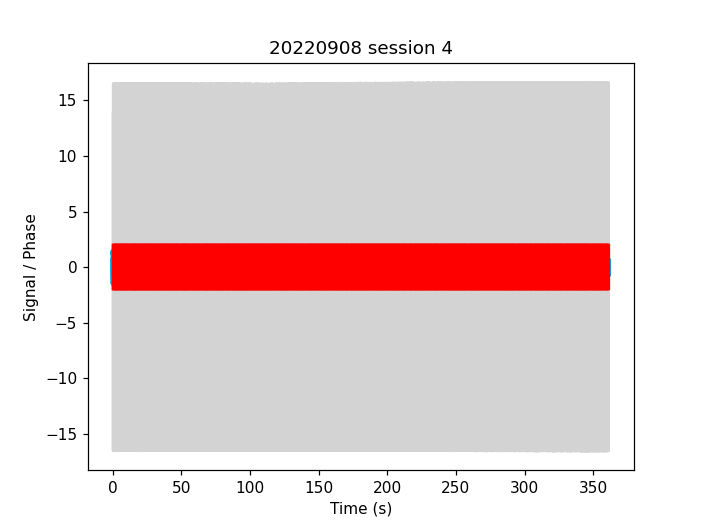

Text(0.5, 1.0, '20220908 session 4')

In [41]:
%matplotlib notebook

### raw signal
plt.plot(session_data.time, session_data.raw/1000, c='lightgray', label='Raw')

# filtered signal
plt.plot(session_data.time, session_data.filtered/1000, lw=3, color='#00AEEF', label='6-10Hz')

### simulated derivative
# plt.plot(time_dict.get(session).get('time')[fltr_buffer_size:], np.array(derv_input)/15, c='green', label='Derv online')

### simulated phase
# plt.plot(time_dict.get(session).get('time')[fltr_buffer_size+1:], phase_history, 
#          c='green', linestyle='-', label='Phase online')

### (critical point) sign buffer history
# plt.step(time_dict.get(session).get('time')[fltr_buffer_size:], sign_history, c='k', label='Sign status')

### simulated events
# plt.scatter(simulated_critical_time, (filtered/1000)[simulated_critical_idx], 
#             c='orange', s=25, zorder=3, label='Simulated stim 1')

### ground truth gradient
# plt.plot(time_dict.get(session).get('time'), np.gradient(filtered)/15, color='r', label='Derv offline')

### ground truth phase
# plt.scatter(time_dict.get(session).get('time'), np.angle(hilbert(filtered)) + np.pi, c='green', s=0.2)

### reward events
# for on_time, duration in zip(reward_on_time, reward_length):
#     plt.plot([on_time, on_time + (duration/1000)], [-1, -1], c='green')

### real events
for on_time in stim_time:
    plt.plot([on_time, on_time], [-2, 2], c='r', lw=1.5)

# plt.plot([0], [0], c='r', label='Stim')

### targets
# plt.scatter(target_time, (session_data.filtered/1000)[target_index],
#             c='k', s=25, zorder=3, label='Target')

# plt.axhline(y=37*np.pi/36, linestyle='--', c='k', lw=2)

# plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Signal / Phase')
plt.title(f'{choose_dates[0]} session {session}')

### Stim length distribution

<IPython.core.display.Javascript object>


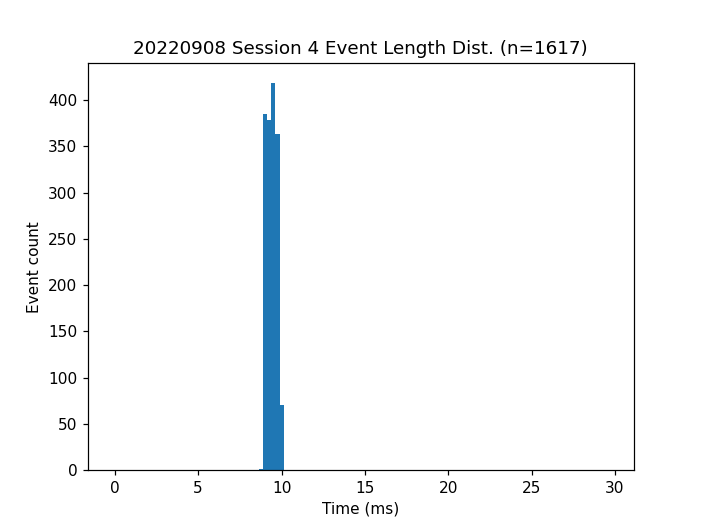

In [42]:
%matplotlib notebook

p_plot.stim_len_hist(session_data, session_param, stim_pump)

### Compare simulated and real events

In [43]:
# real stim events
df_stim_cycles = oc.organize_cycles(session_data,
                                    # target=session_param.stimulation_target, 
                                    # target_index=target_index, 
                                    event_time=stim_time, 
                                    event_timestamp=stim_timestamp, 
                                    )

In [44]:
# -------------------------- SAVE EVENT PHASE DATA FOR GRANT FIGURES --------------------------

# np.savetxt(f'{dir_fig}{choose_dates[0]}_{experiment_name}_{session}_event_phase.csv',
#            np.hstack(df_stim_cycles.get('event_phase')))

<IPython.core.display.Javascript object>


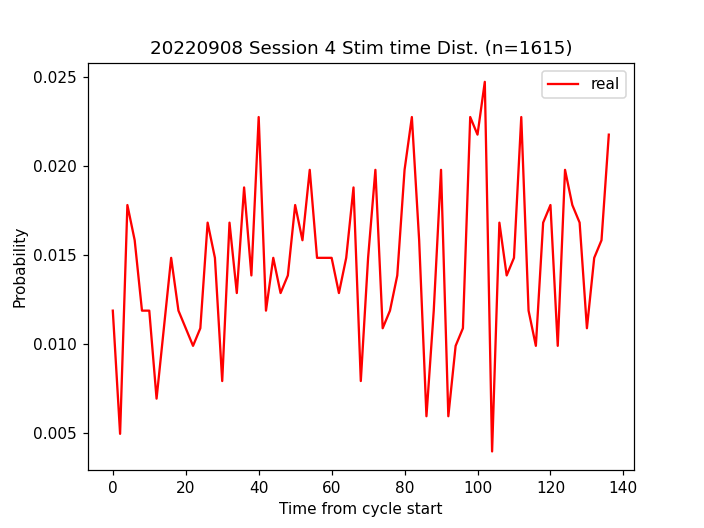

In [45]:
%matplotlib notebook

p_plot.event_aligned_time_hist(df_stim_cycles, session_param)

<IPython.core.display.Javascript object>


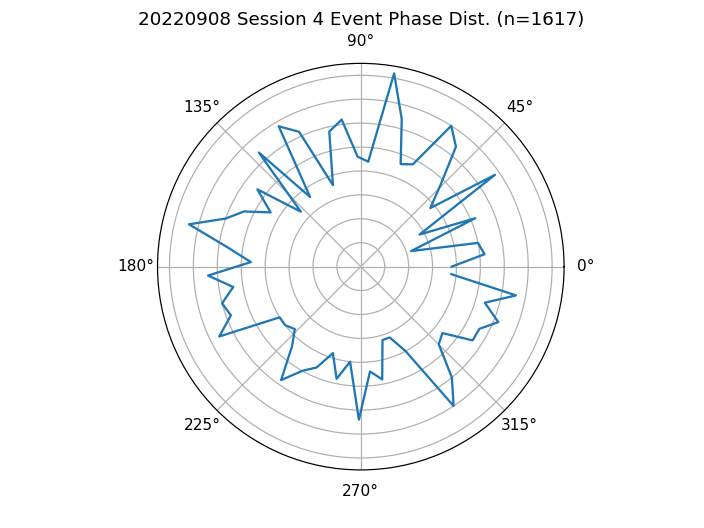

In [46]:
%matplotlib notebook

p_plot.event_phase_hist(session_data, session_param, stim_time)

### Compare good and bad cycles

In [144]:
# # df_cycles = df_simulated_cycles
# # event_type = 'simulated'

# df_cycles = df_stim_cycles
# event_type = 'real'1

<IPython.core.display.Javascript object>


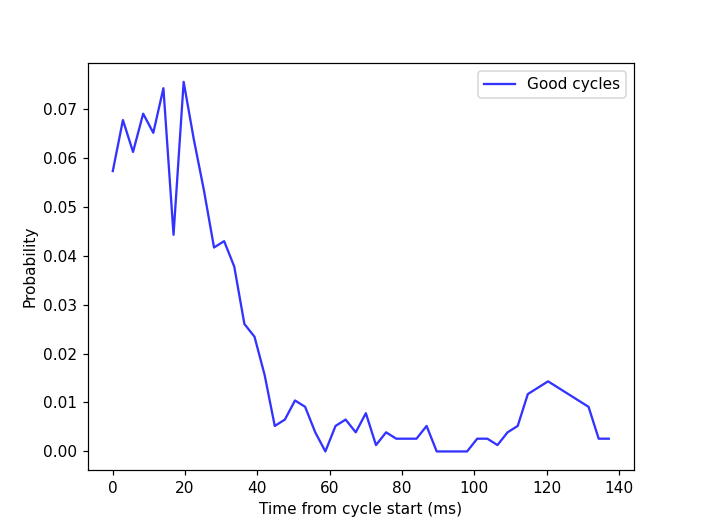

Text(0, 0.5, 'Probability')

In [145]:
# %matplotlib notebook

# '''
# Good group includes all cycles with one stim event, regardless of event phase. OFF events included

# Bad group includes all cycles with more than one stim event. 
# '''

# # event distribution
# stim_good_hist, stim_good_edges = np.histogram(np.hstack(df_cycles[df_cycles['event_count']==1]
#                                                          .get('event_time_aligned').tolist()), 
#                                                bins=50, range=(0,140))

# # stim_bad_hist, stim_bad_edges = np.histogram(np.hstack(df_cycles[df_cycles['event_count']>1]
# #                                                        .get('event_time_aligned').tolist()), 
# #                                                bins=50, range=(0,140))

# # plt.plot(stim_bad_edges[:-1], stim_bad_hist/sum(stim_bad_hist), color='r', alpha=0.4, label='Bad cyclces')
# plt.plot(stim_good_edges[:-1], stim_good_hist/sum(stim_good_hist), color='b', alpha=0.8, label='Good cycles')
# plt.legend()
# plt.xlabel('Time from cycle start (ms)')
# plt.ylabel('Probability')
# # plt.title(f'{choose_dates[0]} s{session}; Good: n=%d, Bad (>1): n=%d; {event_type} events' 
# #           %(len(df_cycles[df_cycles['event_count']==1]), 
# #             len(df_cycles[df_cycles['event_count']>1])))

# # plt.savefig(f"{dir_fig}{choose_dates[0]}_{experiment_name}_session{session}_stim_time_hist.png")

### Signal aligned to stim event groups

In [147]:
# %matplotlib notebook

# single_stim_real = np.hstack(df_cycles[df_cycles['event_count']==1].get('event_time_real'))
# single_stim_aligned = np.hstack(df_cycles[df_cycles['event_count']==1].get('event_time_aligned'))
# single_stim_phase = np.hstack(df_cycles[df_cycles['event_count']==1].get('event_phase'))
# single_target = np.hstack(df_cycles[df_cycles['event_count']==1].get('target_time_real'))

# event time
# good_stim = single_stim_real[np.logical_and(single_phase_lag > phase_lag_lower_bound, 
#                                             single_phase_lag < phase_lag_upper_bound)]

### ------- off stim - stim events delayed to opposite phase -------

# event time
# off_stim = single_stim_real[np.logical_or(single_phase_lag <= phase_lag_lower_bound,
#                                           single_phase_lag >= phase_lag_upper_bound)]

# # cycle/target index
# off_target = single_target[np.logical_or(single_phase_lag <= phase_lag_lower_bound,
#                                         single_phase_lag >= phase_lag_upper_bound)]

### ------- double stim - first ones and second ones ------- 
# double_stim = np.hstack(df_cycles[df_cycles['event_count']==2].get('event_time_real'))
# first_stim = double_stim[::2]
# second_stim = double_stim[1::2]

good_cycle_count = 0
cycles_incl = df_cycles[df_cycles['event_count']>=1]
# includes one, double, and triple stim cycles
for ind, row in cycles_incl.iterrows():
    
    # ------- target falling, stim trough -------
    
#     stim_within_bound = np.logical_or(np.logical_and(row['event_phase']>=3*np.pi/2, 
#                                                      row['event_phase']<2*np.pi),
#                                       row['event_phase']<np.pi/2)
    
#     stim_within_bound = np.logical_or(np.logical_and(row['event_phase']>=7*np.pi/4, 
#                                                      row['event_phase']<2*np.pi),
#                                       row['event_phase']<np.pi/4)
    
    # ------- target trough, stim rising -------
#     stim_within_bound = row['event_phase'] <= np.pi

#     stim_within_bound = np.logical_and(row['event_phase']>=np.pi/8,
#                                        row['event_phase']<3*np.pi/8)
    
#     stim_within_bound = np.logical_and(row['event_phase']>=0,
#                                    row['event_phase']<np.pi/2)
    
    # ------- target rising, stim peak -------
    
#     stim_within_bound = np.logical_and(row['event_phase']>=np.pi/2,
#                                    row['event_phase']<3*np.pi/2)
    
#     stim_within_bound = np.logical_and(row['event_phase']>=3*np.pi/4,
#                                        row['event_phase']<5*np.pi/4)

    # ------- target peak, stim falling -------
#     stim_within_bound = np.logical_and(row['event_phase']>=np.pi,
#                                        row['event_phase']<3*np.pi/2)

    stim_within_bound = np.logical_and(row['event_phase']>=9*np.pi/8,
                                       row['event_phase']<11*np.pi/8)
    
    # ------------------------------------------
    
    good_cycle_count += all(stim_within_bound)

### ------- others -------

# zero_cycle_prct = len(df_cycles[df_cycles['event_count']==0])*100/len(df_cycles)
# more_than_three_cycle_prct = len(df_cycles[df_cycles['event_count']>2])*100/len(df_cycles)

# sizes = [len(good_stim)*100/len(df_cycles), len(off_stim)*100/len(df_cycles),
#          len(first_stim)*100/len(df_cycles), zero_cycle_prct, more_than_three_cycle_prct]
# labels = ['Good', 'Off', 'Double', 'Zero', '>2']

# plt.pie(sizes, labels=labels, shadow=True, autopct='%1.1f%%')
# plt.title(f'{choose_dates[0]} s{session}; {event_type} events')

print(f'Accuracy: {good_cycle_count*100/len(cycles_incl):.2f}%, ' 
      f'Precision: {good_cycle_count*100/len(stim_time):.2f}%')

Accuracy: 26.27%, Precision: 20.74%


In [31]:
# -------------------------- SAVE ACCURACY&PRECISION DATA FOR GRANT FIGURES --------------------------

# np.savetxt(f'{dir_fig}{choose_dates[0]}_{experiment_name}_{session}_accuracy&precision.csv',
#            np.array([good_cycle_count*100/len(df_cycles), 
#                      good_cycle_count*100/len(stim_time)]))

## Label targets and events by groups

In [32]:
# %matplotlib notebook

# ### raw signal
# plt.plot(time_dict.get(session).get('time'), raw/1000, c='lightgray', label='Raw')

# ### filtered signal
# # plt.plot(time_dict.get(session).get('time'), filtered/1000, lw=3, color='#00AEEF', label='6-10Hz')
# plt.plot(time_dict.get(session).get('time'), filtered/1000, lw=3, color='k', label='6-10Hz', alpha=0.5)

# ### reward events
# # for on_time, duration in zip(reward_on_time, reward_length):
# #     plt.plot([on_time, on_time + (duration/1000)], [-1, -1], c='green')

# ### targets
# # plt.scatter(target_time, (filtered/1000)[target_index],
# #             c='k', s=25, zorder=3, label='Target')
    
# # GOOD TARGETS
# plt.scatter(good_target, (filtered/1000)[good_target], c='green', s=25, zorder=3)

# # OTHERS
# other_target = np.append(off_target, np.hstack(df_cycles[df_cycles['event_count']!=1].get('target_time_real')))
# plt.scatter(time[other_target], (filtered/1000)[other_target], c='k', s=25, zorder=3)

# ### real events
# # for on_time in stim_time:
# #     plt.plot([on_time, on_time], [-2, 2], c='r', lw=1.5)

# # GOOD EVENTS
# for good in good_stim:
#     plt.plot([good, good], [-2, 2], c='blue', lw=1.5)
    
# # OFF EVENTS
# for off in off_stim:
#     plt.plot([off, off], [-2, 2], c='red', lw=1.5)

# # MULTIPLE EVENTS
# for double in np.hstack(df_cycles[df_cycles['event_count']>=2].get('event_time_real')):
#     plt.plot([double, double], [-2, 2], c='orange', lw=1.5)
    
# # plt.plot([0], [0], c='r', label='Stim')
# # plt.legend()
# print('Good stim events are shown in blue, off ones in red, multiple ones in orange')
# plt.xlabel('Time (s)')
# # plt.ylabel('Signal (uV)')
# plt.ylabel('Signal / Phase')
# plt.title(f'{choose_dates[0]} session {session} Events Breakdown')

In [ ]:
# stim_group_dict = {}

# win_size = 0.1
# tvals = np.linspace(-win_size, win_size, 300)

# for s_t, n in zip([good_stim, first_stim, second_stim],
#                   ['good', 'first', 'second']):
    
#     raw_stim, time_stim = align_to_events_continuous(raw, time, s_t, win_size)
#     filtered_stim, _ = align_to_events_continuous(filtered, time, s_t, win_size)
    
#     raw_interp = []
#     filtered_interp = []
#     for r, f, t in zip(raw_stim, filtered_stim, time_stim):

#         try:
#             raw_interp.append(np.interp(tvals, t, r))
#             filtered_interp.append(np.interp(tvals, t, f))

#         except ValueError:
#             pass
    
#     stim_group_dict.update({n:{
#         'raw_interp':raw_interp,
#         'filtered_interp':filtered_interp,}})

In [ ]:
# %matplotlib notebook

# group_color_map = {'good':'green',
#                    'off':'gray',
#                    'first':'red',
#                    'second':'blue'}

# signal_type = 'raw'

# for n, s_g in stim_group_dict.items():

#     curr_color = group_color_map.get(n)
#     # avg = np.median(s_g.get(signal_type+'_interp'), axis=0)
#     avg = np.average(s_g.get(signal_type+'_interp'), axis=0)
#     sem = stats.sem(s_g.get(signal_type+'_interp'), axis=0)
#     plt.plot(tvals, avg, c=curr_color)
#     plt.fill_between(tvals, avg-sem, avg+sem, color=curr_color, alpha=0.2)

# for n, color in group_color_map.items():
#     plt.plot([0], [0], c=color, label=n)

# plt.legend()
# plt.title(f'{choose_dates[0]} s{session}; {signal_type};'
#           f' Good: {len(good_stim)}, 1st/2nd: {len(first_stim)}; '+event_type+' events')
# plt.xlabel('Time from event (s)')
# plt.ylabel('Signal (uV)')

# # plt.savefig(f"{dir_fig}{choose_dates[0]}_{experiment_name}_session{session}_stim_event_group_curve.png")

### Lag

In [19]:
# # analyze general lag
# %matplotlib notebook

# lag = np.hstack([stim - target_time for stim in stim_time])*1000

# on_lag_hist, on_lag_edges = np.histogram(lag, np.arange(0,100, 2))

# plt.plot(on_lag_edges[:-1],
#          on_lag_hist/sum(on_lag_hist),)
# plt.xlabel('Lag (ms)')
# plt.title(f'{choose_dates[0]} Session{session} general lag xcorr_hist')

# # plt.savefig(f"{dir_fig}{choose_dates[0]}_{experiment_name}_session{session}_general_lag.png")

# # -------------------------- SAVE STIM-ON LAG DATA FOR GRANT FIGURES --------------------------

# # lag_lowcut = 0
# # lag_highcut = 125
# # on_lag_masked = lag[np.logical_and([lag<lag_highcut], [lag>lag_lowcut])[0]]
# # np.savetxt(f'{dir_fig}{choose_dates[0]}_{experiment_name}_{session}_on_lag_masked.csv', on_lag_masked)